# Суть задания


Генеративные модели (GAN, VAE)\
Общая цель:
Показать понимание архитектур, алгоритмов обучения и функций потерь в GAN, VAE, а также получить практический опыт работы с этими моделями на небольших наборах данных (например, MNIST).

Примерное время выполнения - ??? часов.

Дедлайн: 1 марта в 23:59 \
Сдача в течение 12 часов после дедлайна не штрафуется.

Штрафные коэффициенты оценивания при просрочке:

-|-
----|---
От 12 часов до 7 дней после дедлайна | 0.8
От 7 до 14 дней | 0.6
От 14 дней до конца модуля | 0.4

## Оценивание

Задание:

Критерии оценивания | Коэффициент
-------------|--------------------
Код есть, но не работает | 0
Код работает, но качество генерации хуже образцов | 0.5
Качество генерации не хуже образцов | 1

\


Часть работы | Стоимость в баллах
-------------|--------------------
VAE | 5
GAN | 4
Интерполяция | 1
Итого | 10 баллов

Формула оценивания всей работы:

О = Задание * 0.6 + ответы на вопросы * 0.3 + Тест на лекции * 0.1



Критерии оценивания | Коэффициент
-------------|--------------------
Код есть, но не работает | 0
Код работает, но качество генерации хуже образцов | 0.5
Качество генерации не хуже образцов | 1

# 0 Подготовка системы

## Импорты библиотек

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm

# Задачи

# Задача 1: Реализация и обучение Variational Autoencoder (VAE) (5 баллов)

## Vanilla VAE (2 балла)

* Реализуйте VAE для набора данных MNIST. (0.5 задачи)
  * Реализуйте архитектуру с энкодером, который выводит параметры
𝜇 и 𝜎 для аппроксимированного распределения
𝑞(𝑧∣𝑥), и декодером для реконструкции
𝑥 из 𝑧.
  * Используйте функцию потерь, включающую реконструкционную ошибку (MSE или BCE) и KL-дивергенцию.
  * Обучите модель и визуализируйте результаты:
    * Сравните исходные изображения и реконструкции.
    * Сгенерируйте новые изображения, сэмплируя
* Условная генерация (0.2 задачи)
  * Дополните модель для предоставления возможности условной генерации по заданному классу
* Улучшение модели (0.2 задачи)

### Реализация энкодера

Энкодер - часть VAE, сжимающая входные данные в параметры вероятностного распределения 𝜇 и 𝜎. Для начала реализуйте базовую архитектуру:

Инициализируйте `torch.nn.Module` и определите несколько слоев для дальнейшего использования.

Пожалуйста, используйте следующую структуру сети:
- скрытый слой
 - линейный (полносвязный) слой со входом 784 и hidden_dim выходных измерений
- выходной слой для среднего значения латентного распределения
 - линейный (полносвязный) слой hidden_dim x размерность латентного пространства
- выходной слой для дисперсии латентного распределения
 - линейный (полносвязный) слой hidden_dim x размерность латентного пространства

Также реализуйте прямой проход по сети. В качестве функции активации используйте ReLU.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(Encoder, self).__init__()

        self.fc = nn.Linear(input_dim, hidden_dim)

        self.fc_mean = nn.Linear(hidden_dim, latent_dim)

        self.fc_std = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()
        # YOUR CODE HERE

    def forward(self, x):

        # YOUR CODE HERE
        x = self.fc(x)
        x = self.relu(x)
        mu = self.fc_mean(x)
        logvar = self.fc_std(x)
        return mu, logvar # logvar - логарифм дисперсии. Мы принуждаем модель сразу выучивать его логарифмическое значение. Почему логарифм? Так будет удобнее считать KL divergence.

### Реализация декодера

Декодер - часть VAE, получающая на вход случайных шум размера латентного пространства и восстанавливающий (генерирующий) на его основе данные. Для начала реализуйте базовую архитектуру:

Инициализируйте `torch.nn.Module` и определите несколько слоев для дальнейшего использования.

Пожалуйста, используйте следующую структуру сети:
- скрытый слой
 - линейный (полносвязный) слой со входом с размерностью латентного пространства и выходом размера hidden_dim
- выходной слой
  - линейный (полносвязный) слой со входом hidden_dim x 784 (размерность изначальных данных)



In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim=20, hidden_dim=400, output_dim=784):
        super(Decoder, self).__init__()
        # YOUR CODE HERE
        self.linear = nn.Linear(in_features = latent_dim, out_features = hidden_dim)
        self.out = nn.Linear(in_features = hidden_dim, out_features = output_dim)

        self.relu = nn.ReLU()
        self.sigm = nn.Sigmoid()


    def forward(self, z):
        # YOUR CODE HERE
        hidden = self.relu(self.linear(z))# выход 1-го скрытого слоя

        x_recon = self.sigm(self.out(hidden))# выход модели
        return x_recon

### Собираем вместе



In [ ]:
class VAE(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        # YOUR CODE HERE
        std =  torch.exp(1/2 * logvar)# Вычислите стандартное отклонение c помощью нашего логарифмического: e^(0.5*logvar)
        epsilon = torch.randn_like(std) # Сэмплируйте шум из стандартного нормального распределения, можно сделать через torch.rand
        z = mu + epsilon * std # Reparameterization trick
        return z

    def forward(self, x):
        # YOUR CODE HERE
        mu, logvar = self.encoder(x)
        ## TODO: Вызовите энкодер для вычисления mu и logvar (логарифм дисперсии). Почему логарифм? Так будет удобнее считать KL divergence.
        z = self.reparameterize(mu, logvar)
        ## TODO: Вычислите латентный вектор z через репараметризацию
        x_recon = self.decoder(z)
        ## TODO: Вызовите декодер для вычисления выхода модели
        return x_recon, mu, logvar

### Реализация функции ошибки

In [5]:
# Определите функцию потерь: Потери при реконструкции (BCE) + потери при расхождении KL
def loss_function(recon_x, x, mu, logvar):
    # Вычислите бинарную потерю перекрестной энтропии между реконструированным выходом и оригинальным входом
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') # YOUR CODE HERE

    # Вычислите KL-расхождение между q(z|x) и p(z) = N(0, I)
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

### Реализация обучения

#### Загрузка данных

In [6]:
# Подготовьте датасет MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Разворачиваем изображение в вектор
])

mnist_train = dset.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.36MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 6.74MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Обучение

In [ ]:
hidden_dim = 400 # размерность скрытого слоя
latent_dim = 20 # размерность латентного пространства

# Инициализируйте модель VAE, оптимизатор и устройство настройки
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 10 эпох - очень мало, но подойдёт, чтобы удостовериться, что ваша модель в своей базе работает нормально.
num_epochs = 50 # Для получения более презентабельного результата используйте 50 и больше эпох
model.train()

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        ## YOUR CODE HERE
        data = data.to(device)
        ## TODO: Переместите входные данные (data) на правильное устройство

        optimizer.zero_grad()
        ## TODO: Обнулите градиенты

        recon_batch, mu, logvar = model(data)
        ## TODO: Вычислите выходы энкодера (recon_batch, mu, logvar)

        loss = loss_function(recon_batch, data, mu, logvar)
        ## TODO: Рассчитайте функцию потерь (loss)
        loss.backward()
        ## TODO: Выполните обратное распространение градиентов с учетом функции потерь

        train_loss += loss.item()
        ## TODO: Обновите общий loss, добавив текущий loss

        optimizer.step()
        ## TODO: Выполните шаг оптимизатора

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

Epoch: 0 [0/60000 (0%)]	Loss: 549.542358
Epoch: 0 [12800/60000 (21%)]	Loss: 184.698013
Epoch: 0 [25600/60000 (43%)]	Loss: 155.304474
Epoch: 0 [38400/60000 (64%)]	Loss: 137.396667
Epoch: 0 [51200/60000 (85%)]	Loss: 131.625031
====> Epoch: 0 Average loss: 164.5940
Epoch: 1 [0/60000 (0%)]	Loss: 128.119324
Epoch: 1 [12800/60000 (21%)]	Loss: 123.717270
Epoch: 1 [25600/60000 (43%)]	Loss: 124.673599
Epoch: 1 [38400/60000 (64%)]	Loss: 120.087067
Epoch: 1 [51200/60000 (85%)]	Loss: 112.996399
====> Epoch: 1 Average loss: 121.5380
Epoch: 2 [0/60000 (0%)]	Loss: 114.401680
Epoch: 2 [12800/60000 (21%)]	Loss: 116.072746
Epoch: 2 [25600/60000 (43%)]	Loss: 114.885376
Epoch: 2 [38400/60000 (64%)]	Loss: 112.624268
Epoch: 2 [51200/60000 (85%)]	Loss: 115.083138
====> Epoch: 2 Average loss: 114.4278
Epoch: 3 [0/60000 (0%)]	Loss: 114.816933
Epoch: 3 [12800/60000 (21%)]	Loss: 113.321083
Epoch: 3 [25600/60000 (43%)]	Loss: 112.675644
Epoch: 3 [38400/60000 (64%)]	Loss: 111.154099
Epoch: 3 [51200/60000 (85%)]	Los

### Инференс (генерация)

#### Восстановление входных данных

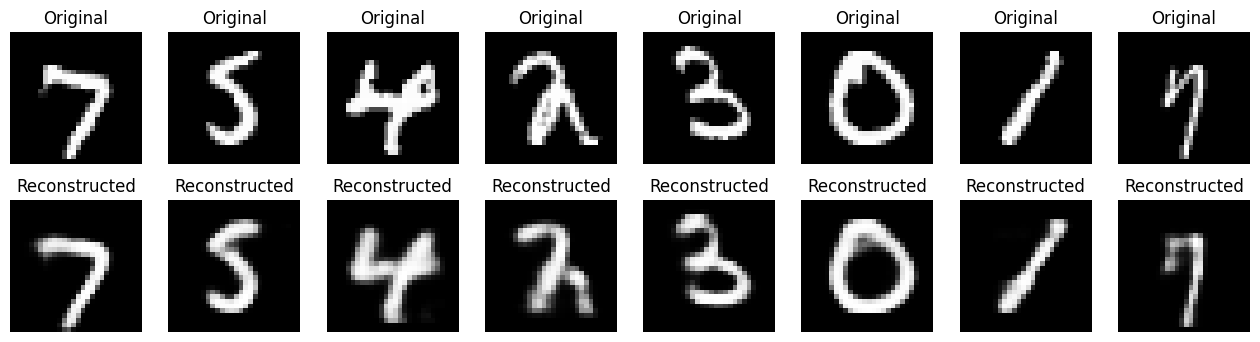

In [ ]:
# Определите то же преобразование, что и во время обучения
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))  # Сплющите изображение (28x28 -> 784)
])

# Загрузите тестовый набор данных MNIST
mnist_test = dset.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=16, shuffle=True)

model.eval()  # Переведите модель в режим оценки

# ---- Визуализация: Реконструкция тестовых изображений ----
# Получите партию тестовых изображений
data_iter = iter(test_loader)
images, _ = next(data_iter)
images = images.to(device)

with torch.no_grad():
    recon_images, mu, logvar = model(images)


plot_images(images, recon_images, n=8)

In [10]:
# Функция построения графика исходного и реконструированного изображений
def plot_images(original, reconstructed, n=8):
    plt.figure(figsize=(16, 4))
    for i in range(n):
        # Оригинальные изображения
        plt.subplot(2, n, i+1)
        plt.imshow(original[i].cpu().view(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis("off")
        # Реконструированные изображения
        plt.subplot(2, n, i+n+1)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

#### Генерация новых изображений

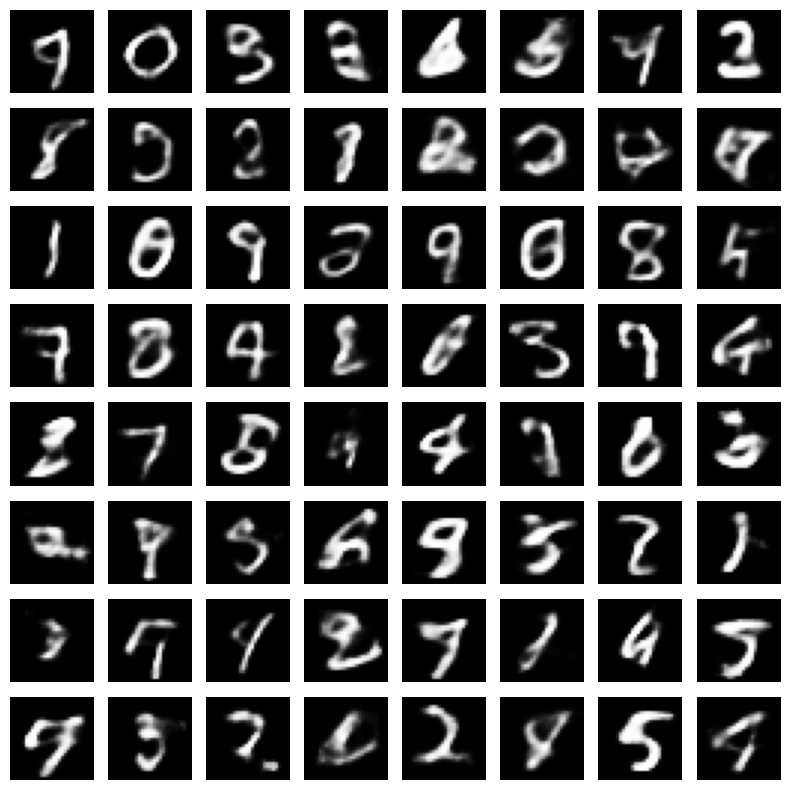

In [ ]:
# ---- Визуализация: Генерация новых изображений из латентного пространства ----
with torch.no_grad():
    # Выборка латентных векторов z из стандартного нормального распределения
    # YOUR CODE HERE:

    z = torch.randn(64, latent_dim).to(device) # 64 образца случайного шума, каждый из которых имеет размерность latent_dim
    generated_images = model.decoder(z)

def plot_generated(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28,28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_generated(generated_images)

## Conditional VAE (2 балла)

Как вы могли заметить, получившаяся модель а) генерирует изображения случайных классов из нашего датасета б) не очень высокого качества. Попробуем что-то с этим сделать. Для начала научим нашу модель генерировать изображения заданного класса. Такая генерация называется условной (conditional generation).

### Определение условного энкодера

Чтобы придать энкодеру возможность работы с метками классов, необходимо добавить (сконкатенировать) эти самые метки с вектором входных данных. Чтобы модель могла эти метки нормально воспринять, их нужно закодировать методом one-hot кодирования (one-hot encoding), позволяющим переводить категориальные данные в численные. При количестве классов 10 каждая метка будет превращаться в вектор такой же длины. Соответственно, вам нужно учесть это дополнение при описании входного слоя модели.

Архитектуру энкодера и декодера можете использовать аналогичную vanilla VAE.

In [ ]:
class ConditionalEncoder(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=400, latent_dim=20):
        super(ConditionalEncoder, self).__init__()
        ## YOUR CODE HERE
        ## TODO: задать скрытый слой модели правильного размера
        self.hidden = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.std = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()


        ## TODO: задать слой для генерации среднего
        ## TODO: задать слой для генерации логарифмической дисперсии

    def forward(self, x, c):
        ## YOUR CODE HERE
        ## TODO: вычислить вектор входных данных с учётом вектора метки класса
        x = self.hidden(torch.cat([x, c], 1))
        x = self.relu(x)

        mu = self.mean(x)
        logvar = self.std(x)

        ## TODO: вычислить среднее и logvar
        return mu, logvar

### Определение условного декодера

С декодером необходимо проделать аналогичные преобразования - добавить возможность подавать на вход вместе с шумом вектор метки класса, чтобы получить ту самую условную генерацию.

In [ ]:
class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim=20, condition_dim=10, hidden_dim=400, output_dim=784):
        super(ConditionalDecoder, self).__init__()
        ## YOUR CODE HERE
        ## TODO: задать скрытые слои декодера правильного размера
        self.hidden = nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()


    def forward(self, z, c):
        ## YOUR CODE HERE
        ## TODO: вычислить вектор входных данных (шум + вектора метки класса)
        x = torch.cat([z,c], 1)
        ## TODO: вычислить вектор скрытого слоя
        x = self.hidden(x)
        x = self.relu(x)
        ## TODO: вычислить выходной вектор (реконструированное/сгенерированное изображение)
        x = self.hidden2(x)
        x_recon = torch.sigmoid(x)
        return x_recon

### Собираем Conditional VAE воедино

In [ ]:
class ConditionalVAE(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=400, latent_dim=50):
        super(ConditionalVAE, self).__init__()
        self.encoder = ConditionalEncoder(input_dim, condition_dim, hidden_dim, latent_dim)
        self.decoder = ConditionalDecoder(latent_dim, condition_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        # YOUR CODE HERE
        std =  torch.exp(1/2 * logvar) # Вычислите стандартное отклонение c помощью нашего логарифмического: e^(0.5*logvar)
        epsilon = torch.rand_like(std)  # Сэмплируйте шум из стандартного нормального распределения, можно сделать через torch.rand
        z = mu + epsilon * std # Reparameterization trick
        return z

    def forward(self, x, c):
        # YOUR CODE HERE
        ## TODO: Вызовите энкодер для вычисления mu и logvar (логарифм дисперсии). Почему логарифм? Так будет удобнее считать KL divergence.
        mu, logvar = self.encoder(x, c)
        ## TODO: Вычислите латентный вектор z через репараметризацию
        z = self.reparameterize(mu, logvar)
        ## TODO: Вызовите декодер для вычисления выхода модели
        x_recon = self.decoder(z, c)
        return x_recon, mu, logvar

Функцию ошибки заново определять не нужно.

### Обучение

In [8]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = dset.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = dset.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
hidden_dim = 400 # размерность скрытого слоя
latent_dim = 20 # размерность латентного пространства

# Инициализируйте модель VAE, оптимизатор и используемое устройство
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConditionalVAE(input_dim=784, condition_dim=10, hidden_dim=hidden_dim, latent_dim=latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
# 10 эпох - очень мало, но подойдёт, чтобы удостовериться, что ваша модель в своей базе работает нормально.
num_epochs = 10 # Для получения более презентабельного результата используйте 50 и больше эпох
model.train()
for epoch in tqdm(range(1, num_epochs + 1)):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        ## YOUR CODE HERE
        ## TODO: Переместите входные данные (data) на правильное устройство
        data = data.to(device)
        ## TODO: Перенесите метки классов (labels) на правильное устройство
        labels = labels.to(device)

        ## TODO: С помощью функции F.one_hot получите массив векторов - закодированных меток классов для вашего батча
        labels = F.one_hot(labels, num_classes=10).float().to(device)

        ## TODO: Обнулите градиенты
        optimizer.zero_grad()

        ## TODO: Вычислите выходы энкодера (recon_batch, mu, logvar)
        recon_batch, mu, logvar = model(data, labels)

        ## TODO: Рассчитайте функцию потерь (loss)
        loss = loss_function(recon_batch, data, mu, logvar)

        ## TODO: Выполните обратное распространение градиентов с учетом функции потерь
        loss.backward()

        ## TODO: Обновите общий loss, добавив текущий loss
        train_loss += loss.item()

        ## TODO: Выполните шаг оптимизатора
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 [0/60000 (0%)]	Loss: 544.966003
Epoch: 1 [12800/60000 (21%)]	Loss: 152.065277
Epoch: 1 [25600/60000 (43%)]	Loss: 122.351334
Epoch: 1 [38400/60000 (64%)]	Loss: 115.147911
Epoch: 1 [51200/60000 (85%)]	Loss: 115.091057


 10%|█         | 1/10 [00:07<01:07,  7.50s/it]

====> Epoch: 1 Average loss: 141.8530
Epoch: 2 [0/60000 (0%)]	Loss: 112.259552
Epoch: 2 [12800/60000 (21%)]	Loss: 102.029701
Epoch: 2 [25600/60000 (43%)]	Loss: 103.397415
Epoch: 2 [38400/60000 (64%)]	Loss: 99.071152
Epoch: 2 [51200/60000 (85%)]	Loss: 96.293594


 20%|██        | 2/10 [00:14<00:58,  7.36s/it]

====> Epoch: 2 Average loss: 101.0220
Epoch: 3 [0/60000 (0%)]	Loss: 99.120712
Epoch: 3 [12800/60000 (21%)]	Loss: 96.346100
Epoch: 3 [25600/60000 (43%)]	Loss: 97.674377
Epoch: 3 [38400/60000 (64%)]	Loss: 94.293121
Epoch: 3 [51200/60000 (85%)]	Loss: 96.871284


 30%|███       | 3/10 [00:21<00:48,  6.94s/it]

====> Epoch: 3 Average loss: 95.0483
Epoch: 4 [0/60000 (0%)]	Loss: 93.819038
Epoch: 4 [12800/60000 (21%)]	Loss: 91.766602
Epoch: 4 [25600/60000 (43%)]	Loss: 90.991089
Epoch: 4 [38400/60000 (64%)]	Loss: 92.604408
Epoch: 4 [51200/60000 (85%)]	Loss: 91.683540


 40%|████      | 4/10 [00:28<00:41,  6.98s/it]

====> Epoch: 4 Average loss: 91.8091
Epoch: 5 [0/60000 (0%)]	Loss: 87.999687
Epoch: 5 [12800/60000 (21%)]	Loss: 93.449898
Epoch: 5 [25600/60000 (43%)]	Loss: 91.424446
Epoch: 5 [38400/60000 (64%)]	Loss: 87.287407
Epoch: 5 [51200/60000 (85%)]	Loss: 90.058914


 50%|█████     | 5/10 [00:34<00:34,  6.82s/it]

====> Epoch: 5 Average loss: 89.6441
Epoch: 6 [0/60000 (0%)]	Loss: 89.195763
Epoch: 6 [12800/60000 (21%)]	Loss: 89.910439
Epoch: 6 [25600/60000 (43%)]	Loss: 88.179337
Epoch: 6 [38400/60000 (64%)]	Loss: 88.144310
Epoch: 6 [51200/60000 (85%)]	Loss: 87.608383


 60%|██████    | 6/10 [00:41<00:27,  6.92s/it]

====> Epoch: 6 Average loss: 88.0945
Epoch: 7 [0/60000 (0%)]	Loss: 86.850861
Epoch: 7 [12800/60000 (21%)]	Loss: 88.208359
Epoch: 7 [25600/60000 (43%)]	Loss: 87.408447
Epoch: 7 [38400/60000 (64%)]	Loss: 82.231232
Epoch: 7 [51200/60000 (85%)]	Loss: 83.805458


 70%|███████   | 7/10 [00:50<00:22,  7.54s/it]

====> Epoch: 7 Average loss: 86.8766
Epoch: 8 [0/60000 (0%)]	Loss: 88.214401
Epoch: 8 [12800/60000 (21%)]	Loss: 86.184494
Epoch: 8 [25600/60000 (43%)]	Loss: 83.576111
Epoch: 8 [38400/60000 (64%)]	Loss: 86.343964
Epoch: 8 [51200/60000 (85%)]	Loss: 81.977959


 80%|████████  | 8/10 [00:57<00:14,  7.19s/it]

====> Epoch: 8 Average loss: 85.9498
Epoch: 9 [0/60000 (0%)]	Loss: 87.475281
Epoch: 9 [12800/60000 (21%)]	Loss: 81.878464
Epoch: 9 [25600/60000 (43%)]	Loss: 89.807678
Epoch: 9 [38400/60000 (64%)]	Loss: 86.779549
Epoch: 9 [51200/60000 (85%)]	Loss: 85.473396


 90%|█████████ | 9/10 [01:04<00:07,  7.15s/it]

====> Epoch: 9 Average loss: 85.2250
Epoch: 10 [0/60000 (0%)]	Loss: 84.898262
Epoch: 10 [12800/60000 (21%)]	Loss: 88.641579
Epoch: 10 [25600/60000 (43%)]	Loss: 86.260193
Epoch: 10 [38400/60000 (64%)]	Loss: 84.459282
Epoch: 10 [51200/60000 (85%)]	Loss: 84.393822


100%|██████████| 10/10 [01:10<00:00,  7.06s/it]

====> Epoch: 10 Average loss: 84.6207


### Восстановление изображений

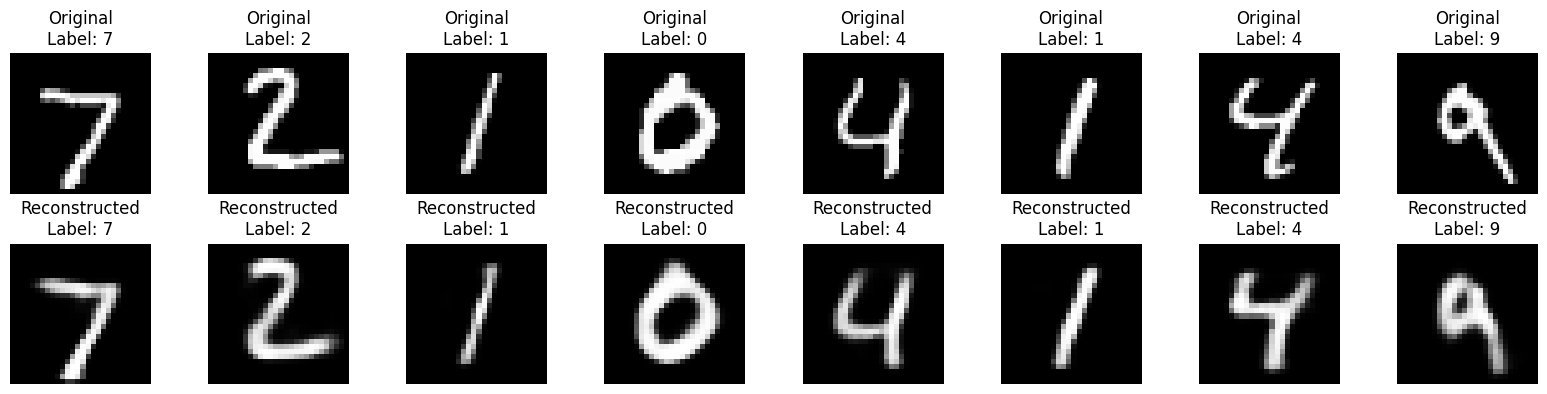

In [ ]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
labels = labels.to(device)

# YOUR CODE HERE:
conditions =  F.one_hot(labels, num_classes=10).float().to(device) # Преобразуйте метки в one-hot кодировку для данного условия.

with torch.no_grad():
    recon_images, mu, logvar = model(images, conditions)

def plot_images(original, reconstructed, conditions, n=8):
    labels = conditions.argmax(dim=1)
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Original\nLabel: {labels[i].item()}")
        plt.axis("off")
        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Reconstructed\nLabel: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_images(images, recon_images, conditions, n=8)

### Сэмплирование новых изображений

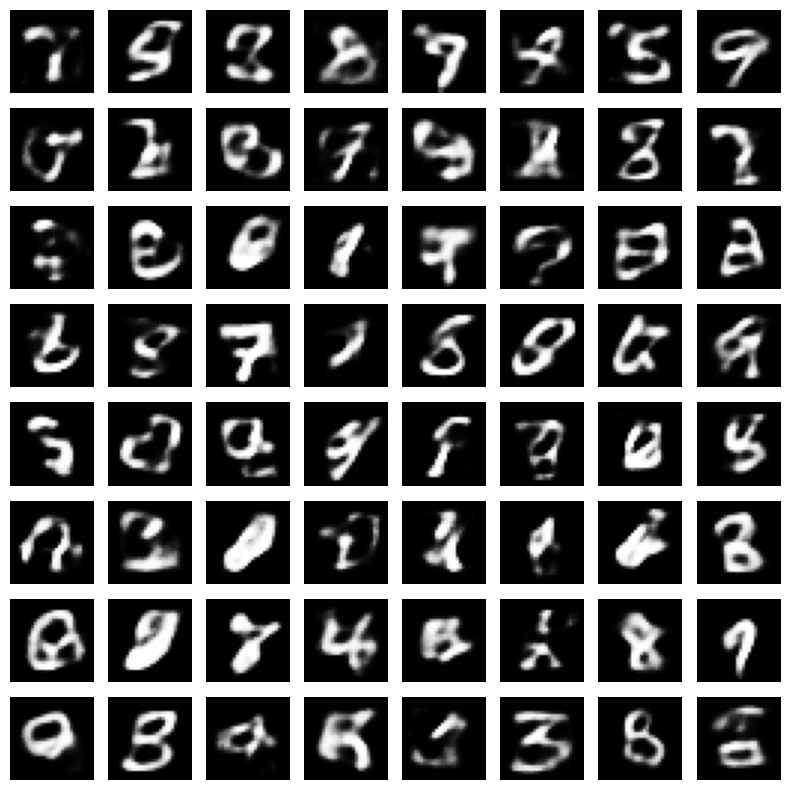

In [ ]:
latent_dim = 20

# ---- Визуализация: Генерация новых изображений из латентного пространства ----
with torch.no_grad():
    # Выборка латентных векторов z из стандартного нормального распределения
    # YOUR CODE HERE:

    z = torch.randn(64, latent_dim).to(device) # 64 образца случайного шума, каждый из которых имеет размерность latent_dim

    random_labels = torch.randint(0, 10, (64,)).to(device)
    conditions = F.one_hot(random_labels, num_classes=10).float().to(device) # С помощью функции F.one_hot получите массив векторов - закодированных меток классов для вашего батча

    generated_images = model.decoder(z, conditions)

def plot_generated(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28,28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

plot_generated(generated_images)

## Улучшение модели (1 балл)


Стало лучше (и визуально, и по значениям loss). Но вы всё ещё можете улучшить приёмами, с которыми вы уже знакомы! Попробуйте поменять различные параметры модели и обучения, чтобы получить более качественные результаты

Например, можете поменять:
- Архитектуру энкодера и декодера (добавить/изменить слои)
- Количество эпох обучения
- Размерность латентного пространства
- Параметры оптимизатора
- ...

In [2]:
# YOUR CODE HERE
# Напишите здесь измененный код для объявления/создания/обучения модели
# (НЕ меняйте код, написанный ранее)

class ConditionalEncoder_v2(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=400, latent_dim=20):
        super(ConditionalEncoder_v2, self).__init__()
        ## YOUR CODE HERE
        ## TODO: задать скрытый слой модели правильного размера
        self.hidden = nn.Linear(input_dim + condition_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, hidden_dim)

        self.mean = nn.Linear(hidden_dim, latent_dim)
        self.std = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()


        ## TODO: задать слой для генерации среднего
        ## TODO: задать слой для генерации логарифмической дисперсии

    def forward(self, x, c):
        ## YOUR CODE HERE
        ## TODO: вычислить вектор входных данных с учётом вектора метки класса
        x = self.hidden(torch.cat([x, c], 1))
        x = self.relu(x)
        x = self.relu(self.hidden2(x))

        mu = self.mean(x)
        logvar = self.std(x)

        ## TODO: вычислить среднее и logvar
        return mu, logvar

In [3]:
class ConditionalDecoder_v2(nn.Module):
    def __init__(self, latent_dim=20, condition_dim=10, hidden_dim=400, output_dim=784):
        super(ConditionalDecoder_v2, self).__init__()
        ## YOUR CODE HERE
        ## TODO: задать скрытые слои декодера правильного размера
        self.hidden = nn.Linear(latent_dim + condition_dim, hidden_dim)
        self.hidden_dop = nn.Linear(hidden_dim, hidden_dim)
        self.hidden2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()


    def forward(self, z, c):
        ## YOUR CODE HERE
        ## TODO: вычислить вектор входных данных (шум + вектора метки класса)
        x = torch.cat([z,c], 1)
        ## TODO: вычислить вектор скрытого слоя
        x = self.hidden(x)
        x = self.relu(x)
        x = self.relu(self.hidden_dop(x))
        ## TODO: вычислить выходной вектор (реконструированное/сгенерированное изображение)
        x = self.hidden2(x)
        x_recon = torch.sigmoid(x)
        return x_recon

In [4]:
class ConditionalVAE_v2(nn.Module):
    def __init__(self, input_dim=784, condition_dim=10, hidden_dim=512, latent_dim=50):
        super(ConditionalVAE_v2, self).__init__()
        self.encoder = ConditionalEncoder_v2(input_dim, condition_dim, hidden_dim, latent_dim)
        self.decoder = ConditionalDecoder_v2(latent_dim, condition_dim, hidden_dim, input_dim)

    def reparameterize(self, mu, logvar):
        # YOUR CODE HERE
        std =  torch.exp(1/2 * logvar) # Вычислите стандартное отклонение c помощью нашего логарифмического: e^(0.5*logvar)
        epsilon = torch.rand_like(std)  # Сэмплируйте шум из стандартного нормального распределения, можно сделать через torch.rand
        z = mu + epsilon * std # Reparameterization trick
        return z

    def forward(self, x, c):
        # YOUR CODE HERE
        ## TODO: Вызовите энкодер для вычисления mu и logvar (логарифм дисперсии). Почему логарифм? Так будет удобнее считать KL divergence.
        mu, logvar = self.encoder(x, c)
        ## TODO: Вычислите латентный вектор z через репараметризацию
        z = self.reparameterize(mu, logvar)
        ## TODO: Вызовите декодер для вычисления выхода модели
        x_recon = self.decoder(z, c)
        return x_recon, mu, logvar

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConditionalVAE_v2(input_dim=784, condition_dim=10).to(device)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-5)

num_epochs = 20
model.train()
for epoch in range(1, num_epochs + 1):
    train_loss = 0
    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = F.one_hot(labels, num_classes=10).float().to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(data):.6f}')
    print(f'====> Epoch: {epoch} Average loss: {train_loss / len(train_loader.dataset):.4f}')


Epoch: 1 [0/60000 (0%)]	Loss: 544.499634
Epoch: 1 [12800/60000 (21%)]	Loss: 176.734787
Epoch: 1 [25600/60000 (43%)]	Loss: 141.454407
Epoch: 1 [38400/60000 (64%)]	Loss: 127.630234
Epoch: 1 [51200/60000 (85%)]	Loss: 121.247711
====> Epoch: 1 Average loss: 152.5092
Epoch: 2 [0/60000 (0%)]	Loss: 123.289284
Epoch: 2 [12800/60000 (21%)]	Loss: 111.499641
Epoch: 2 [25600/60000 (43%)]	Loss: 114.442162
Epoch: 2 [38400/60000 (64%)]	Loss: 101.443512
Epoch: 2 [51200/60000 (85%)]	Loss: 100.971771
====> Epoch: 2 Average loss: 108.0569
Epoch: 3 [0/60000 (0%)]	Loss: 95.603127
Epoch: 3 [12800/60000 (21%)]	Loss: 97.442215
Epoch: 3 [25600/60000 (43%)]	Loss: 98.933159
Epoch: 3 [38400/60000 (64%)]	Loss: 100.154823
Epoch: 3 [51200/60000 (85%)]	Loss: 94.231789
====> Epoch: 3 Average loss: 97.2915
Epoch: 4 [0/60000 (0%)]	Loss: 96.829346
Epoch: 4 [12800/60000 (21%)]	Loss: 90.536659
Epoch: 4 [25600/60000 (43%)]	Loss: 97.012733
Epoch: 4 [38400/60000 (64%)]	Loss: 91.234009
Epoch: 4 [51200/60000 (85%)]	Loss: 91.074

NameError: name 'test_loader' is not defined

In [12]:
def plot_images(original, reconstructed, conditions, n=8):
    labels = conditions.argmax(dim=1)
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Original\nLabel: {labels[i].item()}")
        plt.axis("off")
        plt.subplot(2, n, i + n + 1)
        plt.imshow(reconstructed[i].cpu().view(28, 28), cmap='gray')
        plt.title(f"Reconstructed\nLabel: {labels[i].item()}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

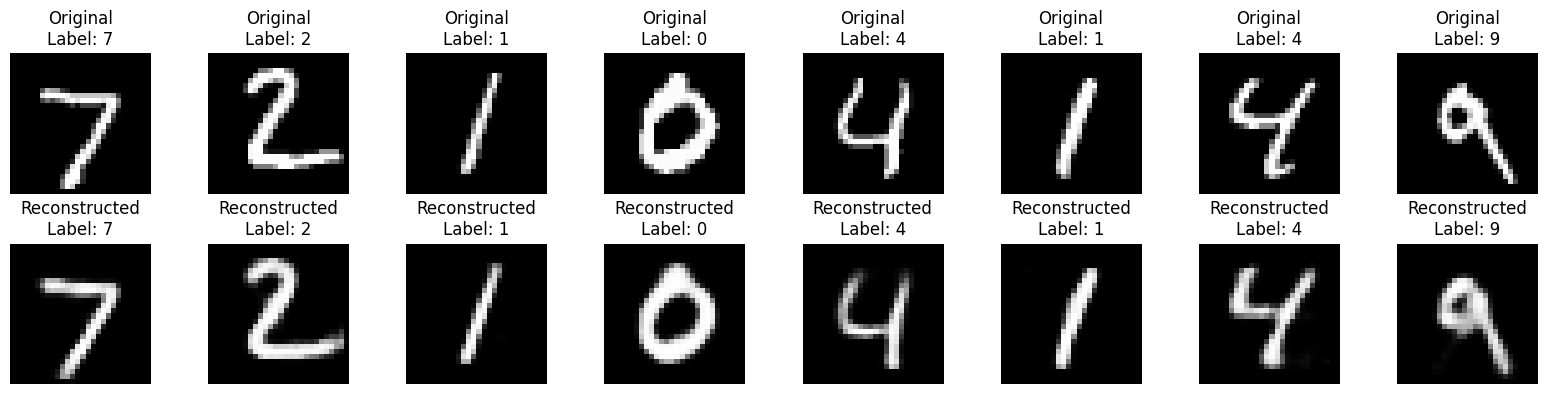

NameError: name 'latent_dim' is not defined

In [13]:
data_iter = iter(test_loader)
images, labels = next(data_iter)
images = images.to(device)
labels = F.one_hot(labels, num_classes=10).float().to(device)

with torch.no_grad():
    recon_images, _, _ = model(images, labels)

plot_images(images, recon_images, labels, n=8)


In [16]:
def plot_generated(images):
    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = images[i].view(28,28).cpu().numpy()
        ax.imshow(img, cmap="gray")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

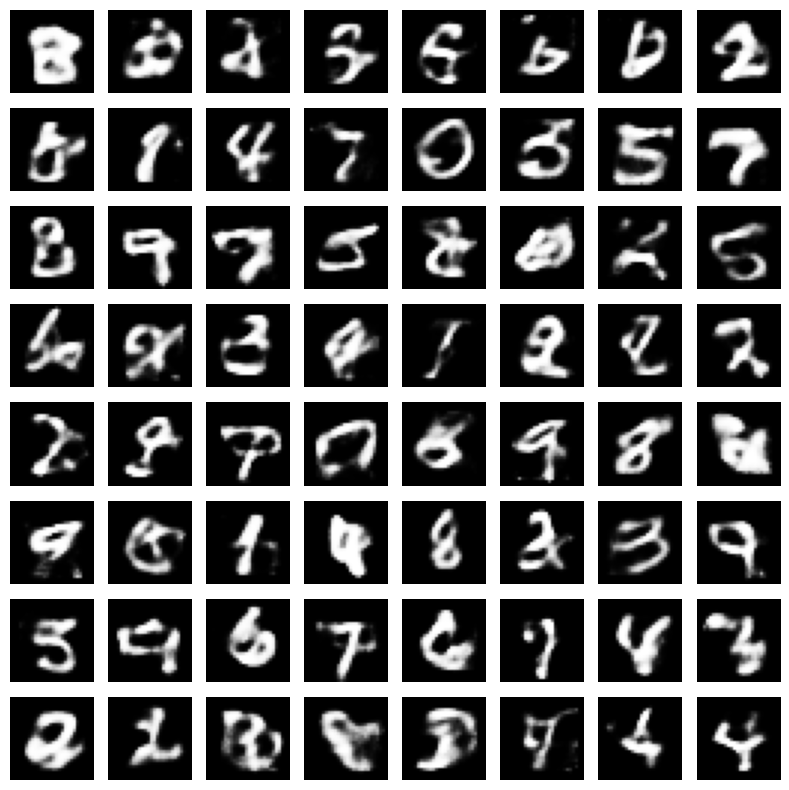

In [17]:
latent_dim = 50

with torch.no_grad():
    z = torch.randn(64, latent_dim).to(device)
    random_labels = torch.randint(0, 10, (64,)).to(device)
    conditions = F.one_hot(random_labels, num_classes=10).float().to(device)
    generated_images = model.decoder(z, conditions)

plot_generated(generated_images)

# Задача 2: Реализация и обучение Generative Adversarial Network GAN (4 балла)

GAN — это класс моделей глубокого обучения, состоящий из двух сетей: генератора и дискриминатора, которые обучаются одновременно: генератор создает данные, а дискриминатор оценивает их достоверность

* **Реализация Vanilla GAN (0.5 задачи)**  
   - Создайте архитектуру GAN, состоящую из:  
     - Генератора, который принимает на вход случайный шум (вектор) и генерирует изображение.  
     - Дискриминатора, который классифицирует изображение как реальное или сгенерированное.  
   - Используйте функцию потерь, основанную на бинарной кросс-энтропии (Binary Cross-Entropy Loss).  
   - Обучите модель, чередуя обновление весов генератора и дискриминатора.  
   - Визуализируйте результаты:  
     - Покажите примеры изображений, сгенерированных обученным генератором.

* **Условная генерация (0.5 задачи)**  
   - Дополните GAN для реализации условной генерации (Conditional GAN, cGAN), где генератор и дискриминатор также принимают на вход метки классов.  
   - Проверьте, как модель справляется с генерацией изображений заданного класса.

## Vanilla GAN (2 балла)

### Реализация генератора

Генератор — это часть GAN, которая создает новые данные, принимая на вход случайный шум и преобразуя его в данные, похожие на реальные. Для начала реализуйте базовую архитектуру:
- линейный слой с параметрами:
  * размер входа - `noise_dim`
  * размер выхода - 256
- функция активации `ReLU()`
- линейный слой с параметрами:
  * размер входа - 256
  * размер выхода - 512
- функция активации `ReLU()`
- линейный слой с параметрами:
  * размер входа - 512
  * размер выхода - 1024
- функция активации `ReLU()`
- линейный слой с параметрами:
  * размер входа - 1024
  * размер выхода - произведение выходных размерностей (размеров изображения) `output_shape`
- функция активации `Tanh()`

In [72]:
class Generator(nn.Module):
    def __init__(self, noise_dim = 100, output_shape = (1, 28, 28)):
        super(Generator, self).__init__()

        self.output_shape = output_shape
        self.fc = nn.Sequential(
            # TODO: Линейный слой (noise_dim, 256)
            nn.Linear(noise_dim, 256),

            # TODO: Функция активации ReLU()
            nn.ReLU(),

            # TODO: Линейный слой (256, 512)
            nn.Linear(256, 512),

            # TODO: Функция активации ReLU()
            nn.ReLU(),

            # TODO: Линейный слой (512, 1024)
            nn.Linear(512, 1024),

            # TODO: Функция активации ReLU()
            nn.ReLU(),

            # TODO: Линейный слой (1024, произведение output_shape)
            nn.Linear(1024, int(torch.prod(torch.tensor(output_shape)))),

            # TODO: Функция активации Tanh()
            nn.Tanh()
        )

    def forward(self, z):
        img = self.fc(z) # TODO: Прогоните пакет векторов через модель и измените его размер до (batch_size, *output_shape)
        img = img.view(img.size(0), *self.output_shape)

        return img

### Реализация дискриминатора

Дискриминатор — это часть GAN, задача которой состоит в классификации входных данных как реальных (из тренировочного набора данных), так и  сгенерированных (созданных генератором).

Он нужен для того, чтобы отличить сгенерированное изображение от настоящего, что затем используется при обучении генератора.

Используйте следующую архитектуру:
* Выровняйте/расплюшьте/разгладьте входное изображение
* Линейный слой с параметрами:
  - размер входа равен произведению размероностей изображения `input_dim`
  - размер выхода равен 1024
* Функция активации LeakyReLU(0.2, inplace=True)
* Линейный слой с параметрами:
  - размер входа равен 1024
  - размер выхода равен 512
* Функция активации LeakyReLU(0.2, inplace=True)
* Линейный слой с параметрами:
  - размер входа равен 512
  - размер выхода равен 256
* Функция активации LeakyReLU(0.2, inplace=True)
* Линейный слой с параметрами:
  - размер входа равен 256
  - размер выхода равен 1
* Функция активации Sigmoid()

In [73]:
class Discriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28)):
        super(Discriminator, self).__init__()
        self.fc = nn.Sequential(

            nn.Flatten(),  # Слой сплющивания
            nn.Linear(int(torch.prod(torch.tensor(input_shape))), 1024),  # Линейный слой (произведение input_shape, 1024)
            nn.LeakyReLU(0.2, inplace=True),  # Функция активации LeakyReLU
            nn.Linear(1024, 512),  # Линейный слой (1024, 512)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),  # Линейный слой (512, 256)
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),  # Линейный слой (256, 1)
            nn.Sigmoid()  # Функция активации Sigmoid

        )

    def forward(self, img):
        result =self.fc(img)  # TODO: Прогоните изображение через дискриминатор
        return result


### Подготовка к обучению

Определите функцию ошибки, создайте моедил генератора и дискриминатора, создайте оптимизаторы для генератора и дискриминатора

In [74]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.view(-1))
])

train_dataset = dset.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = dset.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

criterion = nn.BCELoss()  # Используйте BCE функцию ошибки

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)  # Оптимизатор для генератора
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)  # Оптимизатор для дискриминатора


### Обучение

In [ ]:
from tqdm import tqdm

epochs = 50 # Определите количество эпох
for epoch in tqdm(range(epochs)):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Создайте метки для реальных и фейковых изображений
        real_labels = torch.ones(batch_size, 1).to(device)  # Создайте тензор из единиц
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Создайте тензор из нулей

        # Обучение дискриминатора
        optimizer_d.zero_grad()
        # TODO: Обнулите градиенты дискриминатора

        outputs = discriminator(real_images)  # Прогоните реальные изображения через дискриминатор
        d_loss_real = criterion(outputs, real_labels)  # Вычислите функцию потерь для реальных изображений

        # TODO: Выполните обратное распространение ошибки
        d_loss_real.backward()

        noise = torch.randn(batch_size, 100).to(device)  # Создайте случайный шум
        fake_images = generator(noise) # TODO: Создайте фейковые изображения с помощью генератора
        outputs = discriminator(fake_images.detach()) # TODO: Прогоните фейковые изображения через дискриминатор
        d_loss_fake = criterion(outputs, fake_labels)  # TODO: Вычислите функцию потерь для фейковых изображений

        d_loss_fake.backward()
        # TODO: Выполните обратное распространение ошибки для дискриминатора

        optimizer_d.step()
        # TODO: Выполните шаг оптимизатора дискриминатора

        # Обучение генератора
        # TODO: Обнулите градиенты генератора
        optimizer_g.zero_grad()
        outputs = discriminator(fake_images) # TODO: Прогоните фейковые изображения через дискриминатор
        g_loss = criterion(outputs, real_labels)# TODO: Вычислите функцию потерь для генератора
        # TODO: Выполните обратное распространение ошибки для генератора
        g_loss.backward()

        # TODO: Выполните шаг оптимизатора генератора
        optimizer_g.step()

    # TODO: Выведите результаты текущей эпохи: сумму D Loss и значение G Loss
    print(f'Epoch [{epoch}/{epochs}], D Loss: {d_loss_real + d_loss_fake:.4f}, G Loss: {g_loss:.4f}')


  2%|▏         | 1/50 [00:09<07:37,  9.35s/it]

Epoch [0/50], D Loss: 0.8138, G Loss: 1.3182


  4%|▍         | 2/50 [00:17<07:04,  8.84s/it]

Epoch [1/50], D Loss: 3.2370, G Loss: 4.1688


  6%|▌         | 3/50 [00:25<06:37,  8.46s/it]

Epoch [2/50], D Loss: 1.1730, G Loss: 1.8006


  8%|▊         | 4/50 [00:37<07:19,  9.55s/it]

Epoch [3/50], D Loss: 0.5688, G Loss: 1.9175


 10%|█         | 5/50 [00:47<07:19,  9.76s/it]

Epoch [4/50], D Loss: 0.6573, G Loss: 1.8385


 12%|█▏        | 6/50 [00:55<06:51,  9.35s/it]

Epoch [5/50], D Loss: 0.5768, G Loss: 1.7737


 14%|█▍        | 7/50 [01:03<06:23,  8.91s/it]

Epoch [6/50], D Loss: 0.6869, G Loss: 2.3186


 16%|█▌        | 8/50 [01:12<06:09,  8.80s/it]

Epoch [7/50], D Loss: 0.4735, G Loss: 1.2978


 18%|█▊        | 9/50 [01:20<05:57,  8.71s/it]

Epoch [8/50], D Loss: 0.2168, G Loss: 2.0233


 20%|██        | 10/50 [01:29<05:43,  8.59s/it]

Epoch [9/50], D Loss: 0.3937, G Loss: 2.4903


 22%|██▏       | 11/50 [01:37<05:30,  8.47s/it]

Epoch [10/50], D Loss: 0.3358, G Loss: 2.5792


 24%|██▍       | 12/50 [01:45<05:22,  8.49s/it]

Epoch [11/50], D Loss: 0.7038, G Loss: 5.3194


 26%|██▌       | 13/50 [01:54<05:13,  8.49s/it]

Epoch [12/50], D Loss: 0.5565, G Loss: 2.7792


 28%|██▊       | 14/50 [02:02<04:58,  8.31s/it]

Epoch [13/50], D Loss: 0.4444, G Loss: 3.8514


 30%|███       | 15/50 [02:10<04:52,  8.36s/it]

Epoch [14/50], D Loss: 0.5178, G Loss: 4.7121


 32%|███▏      | 16/50 [02:19<04:45,  8.39s/it]

Epoch [15/50], D Loss: 0.4190, G Loss: 7.3648


 34%|███▍      | 17/50 [02:27<04:31,  8.23s/it]

Epoch [16/50], D Loss: 0.3613, G Loss: 3.6308


 36%|███▌      | 18/50 [02:35<04:26,  8.32s/it]

Epoch [17/50], D Loss: 1.4857, G Loss: 2.2485


 38%|███▊      | 19/50 [02:44<04:20,  8.42s/it]

Epoch [18/50], D Loss: 0.5026, G Loss: 4.1133


 40%|████      | 20/50 [02:52<04:10,  8.36s/it]

Epoch [19/50], D Loss: 0.2610, G Loss: 3.3636


 42%|████▏     | 21/50 [03:02<04:18,  8.91s/it]

Epoch [20/50], D Loss: 1.9430, G Loss: 1.3797


 44%|████▍     | 22/50 [03:11<04:06,  8.81s/it]

Epoch [21/50], D Loss: 0.6426, G Loss: 2.8149


 46%|████▌     | 23/50 [03:19<03:55,  8.71s/it]

Epoch [22/50], D Loss: 1.2918, G Loss: 3.4855


 48%|████▊     | 24/50 [03:27<03:40,  8.48s/it]

Epoch [23/50], D Loss: 0.2890, G Loss: 3.4033


 50%|█████     | 25/50 [03:36<03:32,  8.49s/it]

Epoch [24/50], D Loss: 0.5394, G Loss: 3.7442


 52%|█████▏    | 26/50 [03:45<03:27,  8.66s/it]

Epoch [25/50], D Loss: 0.5422, G Loss: 4.0647


 54%|█████▍    | 27/50 [03:55<03:28,  9.04s/it]

Epoch [26/50], D Loss: 0.1836, G Loss: 5.0454


 56%|█████▌    | 28/50 [04:03<03:14,  8.83s/it]

Epoch [27/50], D Loss: 0.5962, G Loss: 4.3766


 58%|█████▊    | 29/50 [04:13<03:12,  9.16s/it]

Epoch [28/50], D Loss: 1.0641, G Loss: 3.1651


 60%|██████    | 30/50 [04:22<03:01,  9.10s/it]

Epoch [29/50], D Loss: 0.2776, G Loss: 4.5160


 62%|██████▏   | 31/50 [04:31<02:51,  9.05s/it]

Epoch [30/50], D Loss: 0.1103, G Loss: 4.0031


 64%|██████▍   | 32/50 [04:39<02:40,  8.90s/it]

Epoch [31/50], D Loss: 0.2134, G Loss: 2.7851


 66%|██████▌   | 33/50 [04:48<02:32,  8.95s/it]

Epoch [32/50], D Loss: 0.1196, G Loss: 4.1825


 68%|██████▊   | 34/50 [04:57<02:20,  8.81s/it]

Epoch [33/50], D Loss: 0.1044, G Loss: 7.0868


 70%|███████   | 35/50 [05:05<02:10,  8.71s/it]

Epoch [34/50], D Loss: 0.2890, G Loss: 3.5562


 72%|███████▏  | 36/50 [05:14<02:03,  8.80s/it]

Epoch [35/50], D Loss: 0.2211, G Loss: 4.8793


 74%|███████▍  | 37/50 [05:24<01:59,  9.16s/it]

Epoch [36/50], D Loss: 0.4472, G Loss: 4.7607


 76%|███████▌  | 38/50 [05:37<02:02, 10.21s/it]

Epoch [37/50], D Loss: 0.3877, G Loss: 7.5572


 78%|███████▊  | 39/50 [05:47<01:51, 10.18s/it]

Epoch [38/50], D Loss: 0.5127, G Loss: 2.5541


 80%|████████  | 40/50 [05:56<01:36,  9.67s/it]

Epoch [39/50], D Loss: 0.5764, G Loss: 4.3652


 82%|████████▏ | 41/50 [06:04<01:23,  9.23s/it]

Epoch [40/50], D Loss: 0.1978, G Loss: 3.0464


 84%|████████▍ | 42/50 [06:13<01:14,  9.32s/it]

Epoch [41/50], D Loss: 0.1230, G Loss: 4.2646


 86%|████████▌ | 43/50 [06:22<01:04,  9.22s/it]

Epoch [42/50], D Loss: 0.3843, G Loss: 5.5210


 88%|████████▊ | 44/50 [06:31<00:55,  9.19s/it]

Epoch [43/50], D Loss: 0.3261, G Loss: 4.7146


 90%|█████████ | 45/50 [06:40<00:44,  8.97s/it]

Epoch [44/50], D Loss: 0.3699, G Loss: 4.8798


 92%|█████████▏| 46/50 [06:48<00:35,  8.84s/it]

Epoch [45/50], D Loss: 0.2993, G Loss: 4.1906


 94%|█████████▍| 47/50 [06:57<00:26,  8.73s/it]

Epoch [46/50], D Loss: 0.4778, G Loss: 2.7255


 96%|█████████▌| 48/50 [07:05<00:17,  8.57s/it]

Epoch [47/50], D Loss: 0.3770, G Loss: 5.0834


 98%|█████████▊| 49/50 [07:17<00:09,  9.55s/it]

Epoch [48/50], D Loss: 0.4643, G Loss: 3.1194


100%|██████████| 50/50 [07:28<00:00,  8.97s/it]

Epoch [49/50], D Loss: 0.5185, G Loss: 4.9940


In [84]:
from tqdm import tqdm

epochs = 20 # Определите количество эпох
for epoch in tqdm(range(epochs)):
    for i, (real_images, _) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        # Создайте метки для реальных и фейковых изображений
        real_labels = torch.ones(batch_size, 1).to(device)  # Создайте тензор из единиц
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Создайте тензор из нулей

        # Обучение дискриминатора
        optimizer_d.zero_grad()
        # TODO: Обнулите градиенты дискриминатора

        outputs = discriminator(real_images)  # Прогоните реальные изображения через дискриминатор
        d_loss_real = criterion(outputs, real_labels)  # Вычислите функцию потерь для реальных изображений

        # TODO: Выполните обратное распространение ошибки
        d_loss_real.backward()

        noise = torch.randn(batch_size, 100).to(device)  # Создайте случайный шум
        fake_images = generator(noise) # TODO: Создайте фейковые изображения с помощью генератора
        outputs = discriminator(fake_images.detach()) # TODO: Прогоните фейковые изображения через дискриминатор
        d_loss_fake = criterion(outputs, fake_labels)  # TODO: Вычислите функцию потерь для фейковых изображений

        d_loss_fake.backward()
        # TODO: Выполните обратное распространение ошибки для дискриминатора

        optimizer_d.step()
        # TODO: Выполните шаг оптимизатора дискриминатора

        # Обучение генератора
        # TODO: Обнулите градиенты генератора
        optimizer_g.zero_grad()
        outputs = discriminator(fake_images) # TODO: Прогоните фейковые изображения через дискриминатор
        g_loss = criterion(outputs, real_labels)# TODO: Вычислите функцию потерь для генератора
        # TODO: Выполните обратное распространение ошибки для генератора
        g_loss.backward()

        # TODO: Выполните шаг оптимизатора генератора
        optimizer_g.step()

    # TODO: Выведите результаты текущей эпохи: сумму D Loss и значение G Loss
    print(f'Epoch [{epoch}/{epochs}], D Loss: {d_loss_real + d_loss_fake:.4f}, G Loss: {g_loss:.4f}')


  5%|▌         | 1/20 [00:08<02:46,  8.77s/it]

Epoch [0/20], D Loss: 0.2101, G Loss: 4.1908


 10%|█         | 2/20 [00:17<02:38,  8.79s/it]

Epoch [1/20], D Loss: 0.1640, G Loss: 6.4198


 15%|█▌        | 3/20 [00:26<02:26,  8.63s/it]

Epoch [2/20], D Loss: 0.1321, G Loss: 3.7162


 20%|██        | 4/20 [00:35<02:21,  8.86s/it]

Epoch [3/20], D Loss: 0.2325, G Loss: 6.8462


 25%|██▌       | 5/20 [00:44<02:17,  9.14s/it]

Epoch [4/20], D Loss: 0.1763, G Loss: 4.1447


 30%|███       | 6/20 [00:53<02:05,  9.00s/it]

Epoch [5/20], D Loss: 0.3614, G Loss: 5.1162


 35%|███▌      | 7/20 [01:02<01:54,  8.81s/it]

Epoch [6/20], D Loss: 0.1550, G Loss: 6.3400


 40%|████      | 8/20 [01:10<01:44,  8.72s/it]

Epoch [7/20], D Loss: 0.4110, G Loss: 7.1160


 45%|████▌     | 9/20 [01:19<01:36,  8.76s/it]

Epoch [8/20], D Loss: 0.2371, G Loss: 5.9161


 50%|█████     | 10/20 [01:28<01:27,  8.75s/it]

Epoch [9/20], D Loss: 0.2327, G Loss: 5.0593


 55%|█████▌    | 11/20 [01:36<01:17,  8.60s/it]

Epoch [10/20], D Loss: 0.1107, G Loss: 7.0595


 60%|██████    | 12/20 [01:45<01:09,  8.70s/it]

Epoch [11/20], D Loss: 0.1671, G Loss: 6.6756


 65%|██████▌   | 13/20 [01:54<01:01,  8.75s/it]

Epoch [12/20], D Loss: 0.1783, G Loss: 4.2695


 70%|███████   | 14/20 [02:02<00:52,  8.72s/it]

Epoch [13/20], D Loss: 0.2087, G Loss: 5.3387


 75%|███████▌  | 15/20 [02:11<00:43,  8.61s/it]

Epoch [14/20], D Loss: 0.1230, G Loss: 5.1884


 80%|████████  | 16/20 [02:20<00:34,  8.70s/it]

Epoch [15/20], D Loss: 0.0519, G Loss: 5.2547


 85%|████████▌ | 17/20 [02:28<00:26,  8.72s/it]

Epoch [16/20], D Loss: 0.1899, G Loss: 6.2346


 90%|█████████ | 18/20 [02:37<00:17,  8.56s/it]

Epoch [17/20], D Loss: 0.2465, G Loss: 4.9485


 95%|█████████▌| 19/20 [02:45<00:08,  8.59s/it]

Epoch [18/20], D Loss: 0.2958, G Loss: 7.4785


100%|██████████| 20/20 [02:54<00:00,  8.72s/it]

Epoch [19/20], D Loss: 0.2587, G Loss: 4.3489


### Сэмплирование изображений

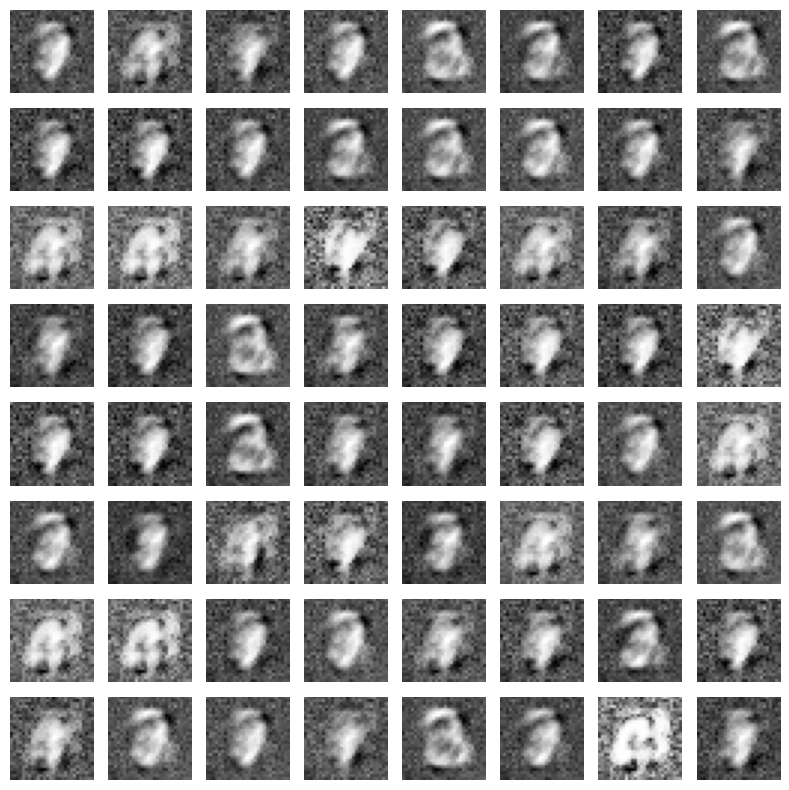

In [87]:
import matplotlib.pyplot as plt

# YOUR CODE HERE:
z = torch.randn(64, 100).to(device) # 64 образца случайного шума, каждый из которых имеет размерность noise_dim
generated_images = generator(z).cpu().detach()

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = generated_images[i].view(28,28).numpy()
    ax.imshow(img, cmap="gray")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Conditional GAN (2 балла)

Аналогично с Conditional VAE попробуем улучшить качество генерации и получить возможность управлять ей при помощи создания Conditional GAN.

### Условный генератор

Чтобы придать генератору возможность работы с метками классов, необходимо добавить (сконкатенировать) эти самые метки с вектором шума. Как и раньше метки кодируются при помощи one-hot encoding. Соответственно, вам нужно учесть это дополнение при описании входного слоя модели.

Архитектуры генератора и дискриминатора можете использовать аналогичные Vanilla GAN.

In [18]:
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim=100, num_classes=10, output_shape=(1, 28, 28)):
        super(ConditionalGenerator, self).__init__()
        self.output_shape = output_shape
        self.img_size = int(torch.prod(torch.tensor(output_shape))) # TODO: Вычислите размер выходного изображения (произведение размерностей output_shape)

        self.fc = nn.Sequential(
            # TODO: Линейный слой (noise_dim + num_classes, 256)
            nn.Linear(noise_dim + num_classes, 256),
            # TODO: Функция активации ReLU(True)
            nn.ReLU(True),
            # TODO: Линейный слой (256, 512)
            nn.Linear(256, 512),
            # TODO: Функция активации ReLU(True)
            nn.ReLU(True),
            # TODO: Линейный слой (512, 1024)
            nn.Linear(512, 1024),
            # TODO: Функция активации ReLU(True)
            nn.ReLU(True),
            # TODO: Линейный слой (1024, self.img_size)
            nn.Linear(1024, self.img_size),
            # TODO: Функция активации Tanh()
            nn.Tanh()
        )

    def forward(self, z, c):
        # TODO: Объедините шум z и условный вектор c
        x = torch.cat((z, c), dim=1)
        x = self.fc(x).view(-1, *self.output_shape) # TODO: Прогоните объединённый вектор через fc и преобразуйте результат в форму изображения
        return x

### Условный дискриминатор

С дискриминатором необходимо проделать аналогичные преобразования - добавить возможность подавать на вход вместе с изображением вектор метки класса.

In [19]:
import torch
import torch.nn as nn

class ConditionalDiscriminator(nn.Module):
    def __init__(self, input_shape=(1, 28, 28), num_classes=10):
        super(ConditionalDiscriminator, self).__init__()
        self.input_shape = input_shape
        self.num_classes = num_classes

        self.img_dim = int(torch.prod(torch.tensor(input_shape))) # TODO: Вычислите размерность изображения (произведение размерностей input_shape)

        input_dim =  self.img_dim + num_classes  # TODO: Определите размер входного вектора (сумма img_dim и num_classes)

        self.fc = nn.Sequential(
            # TODO: Линейный слой (input_dim, 1024)
            nn.Linear(input_dim, 1024),
            # TODO: Функция активации LeakyReLU(0.2, inplace=True)
            nn.LeakyReLU(0.2, inplace=True),
            # TODO: Линейный слой (1024, 512)
            nn.Linear(1024, 512),
            # TODO: Функция активации LeakyReLU(0.2, inplace=True)
            nn.LeakyReLU(0.2, inplace=True),
             # TODO: Линейный слой (512, 256)
            nn.Linear(512, 256),
            # TODO: Функция активации LeakyReLU(0.2, inplace=True)
            nn.LeakyReLU(0.2, inplace=True),
            # TODO: Линейный слой (256, 1)
            nn.Linear(256, 1),
            # TODO: Функция активации Sigmoid()
            nn.Sigmoid()
        )

    def forward(self, img, c):
        img_flat = img.view(img.size(0), -1)  # TODO: Разгладьте изображение в вектор (размерность: batch_size x img_dim)
        x = torch.cat((img_flat, c), dim=1) # TODO: Объедините векторы изображения и метки классов и используйте модель
        x = self.fc(x)
        return x


### Подготовка к обучению

In [20]:
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

batch_size = 128
lr = 0.0004
noise_dim = 100
num_classes = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [21]:
import torchvision
import torch.optim as optim

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

generator = ConditionalGenerator(noise_dim=noise_dim, num_classes=num_classes, output_shape=(1, 28, 28)).to(device)
discriminator = ConditionalDiscriminator(input_shape=(1, 28, 28), num_classes=num_classes).to(device)

criterion = nn.BCELoss()  # Определите функцию ошибки BCE
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002) # Определите оптимизатор для генератора
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002) # Определите оптимизатор для генератора

### Обучение

In [69]:
from tqdm import tqdm

epochs = 50 # Определите количество эпох
for epoch in tqdm(range(epochs)):
    for i, (real_images, labels) in enumerate(train_loader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)

        labels = F.one_hot(labels, num_classes).float().to(device)

        # Создайте метки для реальных и фейковых изображений
        real_labels = torch.ones(batch_size, 1).to(device)  # Создайте тензор из единиц
        fake_labels = torch.zeros(batch_size, 1).to(device)  # Создайте тензор из нулей

        # Обучение дискриминатора
        # TODO: Обнулите градиенты дискриминатора
        optimizer_D.zero_grad()

        outputs = discriminator(real_images, labels)  # TODO: Прогоните реальные изображения и метки через дискриминатор
        d_loss_real = criterion(outputs, real_labels) # TODO: Вычислите функцию потерь для реальных изображений

        # TODO: Выполните обратное распространение ошибки
        d_loss_real.backward()

        noise = torch.randn(batch_size, noise_dim).to(device)  # Создайте случайный шум
        fake_images = generator(noise, labels)  # Создайте фейковые изображения с помощью генератора
        outputs = discriminator(fake_images.detach(), labels)  # Прогоните фейковые изображения через дискриминатор
        d_loss_fake = criterion(outputs, fake_labels)  # Вычислите функцию потерь для фейковых изображений
        d_loss_fake.backward()  # Выполните обратное распространение ошибки для дискриминатора

        # TODO: Выполните шаг оптимизатора дискриминатора
        optimizer_D.step()

        # Обучение генератора
        # TODO: Обнулите градиенты генератора
        optimizer_G.zero_grad()
        outputs = discriminator(fake_images, labels) # TODO: Прогоните фейковые изображения через дискриминатор
        g_loss = criterion(outputs, real_labels)  # TODO: Вычислите функцию потерь для генератора

        # TODO: Выполните обратное распространение ошибки для генератора
        g_loss.backward()

        # TODO: Выполните шаг оптимизатора генератора
        optimizer_G.step()

    # TODO: Выведите результаты текущей эпохи: сумму D Loss и значение G Loss
    print(f'Epoch [{epoch}/{epochs}], D Loss: {d_loss_real.item() + d_loss_fake.item():.4f}, G Loss: {g_loss.item():.4f}')


  2%|▏         | 1/50 [00:15<12:18, 15.07s/it]

Epoch [0/50], D Loss: 0.2440, G Loss: 8.3869


  4%|▍         | 2/50 [00:30<12:00, 15.01s/it]

Epoch [1/50], D Loss: 0.1229, G Loss: 9.3207


  6%|▌         | 3/50 [00:45<11:52, 15.16s/it]

Epoch [2/50], D Loss: 0.1795, G Loss: 5.4273


  8%|▊         | 4/50 [01:00<11:41, 15.24s/it]

Epoch [3/50], D Loss: 0.5913, G Loss: 3.9530


 10%|█         | 5/50 [01:15<11:20, 15.12s/it]

Epoch [4/50], D Loss: 0.4378, G Loss: 7.1597


 12%|█▏        | 6/50 [01:30<11:02, 15.06s/it]

Epoch [5/50], D Loss: 0.0923, G Loss: 5.2016


 14%|█▍        | 7/50 [01:45<10:45, 15.02s/it]

Epoch [6/50], D Loss: 0.1300, G Loss: 6.1554


 16%|█▌        | 8/50 [02:01<10:37, 15.17s/it]

Epoch [7/50], D Loss: 0.3431, G Loss: 3.8863


 18%|█▊        | 9/50 [02:16<10:21, 15.15s/it]

Epoch [8/50], D Loss: 0.9495, G Loss: 3.3208


 20%|██        | 10/50 [02:31<10:03, 15.10s/it]

Epoch [9/50], D Loss: 0.1726, G Loss: 5.9534


 22%|██▏       | 11/50 [02:46<09:46, 15.04s/it]

Epoch [10/50], D Loss: 0.3078, G Loss: 5.5086


 24%|██▍       | 12/50 [03:01<09:36, 15.16s/it]

Epoch [11/50], D Loss: 0.1937, G Loss: 4.5592


 26%|██▌       | 13/50 [03:16<09:15, 15.02s/it]

Epoch [12/50], D Loss: 0.4893, G Loss: 4.5611


 28%|██▊       | 14/50 [03:30<08:56, 14.90s/it]

Epoch [13/50], D Loss: 0.3162, G Loss: 7.1638


 30%|███       | 15/50 [03:45<08:39, 14.84s/it]

Epoch [14/50], D Loss: 0.1825, G Loss: 4.2289


 32%|███▏      | 16/50 [04:00<08:25, 14.87s/it]

Epoch [15/50], D Loss: 0.4670, G Loss: 4.1743


 34%|███▍      | 17/50 [04:15<08:13, 14.97s/it]

Epoch [16/50], D Loss: 0.3660, G Loss: 3.4542


 36%|███▌      | 18/50 [04:30<07:53, 14.81s/it]

Epoch [17/50], D Loss: 0.2336, G Loss: 5.5931


 38%|███▊      | 19/50 [04:44<07:35, 14.69s/it]

Epoch [18/50], D Loss: 0.2461, G Loss: 4.3332


 40%|████      | 20/50 [04:59<07:20, 14.68s/it]

Epoch [19/50], D Loss: 0.3036, G Loss: 3.0607


 42%|████▏     | 21/50 [05:13<07:05, 14.69s/it]

Epoch [20/50], D Loss: 0.2653, G Loss: 4.1312


 44%|████▍     | 22/50 [05:28<06:52, 14.73s/it]

Epoch [21/50], D Loss: 0.6149, G Loss: 4.0100


 46%|████▌     | 23/50 [05:43<06:36, 14.67s/it]

Epoch [22/50], D Loss: 0.4066, G Loss: 4.1772


 48%|████▊     | 24/50 [05:57<06:20, 14.62s/it]

Epoch [23/50], D Loss: 0.3514, G Loss: 2.7174


 50%|█████     | 25/50 [06:12<06:03, 14.56s/it]

Epoch [24/50], D Loss: 0.2673, G Loss: 4.2438


 52%|█████▏    | 26/50 [06:26<05:45, 14.40s/it]

Epoch [25/50], D Loss: 0.3796, G Loss: 4.2246


 54%|█████▍    | 27/50 [06:40<05:30, 14.35s/it]

Epoch [26/50], D Loss: 0.3243, G Loss: 4.8024


 56%|█████▌    | 28/50 [06:53<05:11, 14.14s/it]

Epoch [27/50], D Loss: 0.3494, G Loss: 3.8891


 58%|█████▊    | 29/50 [07:07<04:55, 14.06s/it]

Epoch [28/50], D Loss: 0.4368, G Loss: 3.9525


 60%|██████    | 30/50 [07:21<04:40, 14.02s/it]

Epoch [29/50], D Loss: 0.4564, G Loss: 3.1696


 62%|██████▏   | 31/50 [07:35<04:25, 13.99s/it]

Epoch [30/50], D Loss: 0.4465, G Loss: 3.1377


 64%|██████▍   | 32/50 [07:50<04:14, 14.17s/it]

Epoch [31/50], D Loss: 0.3676, G Loss: 3.8468


 66%|██████▌   | 33/50 [08:05<04:06, 14.51s/it]

Epoch [32/50], D Loss: 0.3058, G Loss: 3.0409


 68%|██████▊   | 34/50 [08:20<03:53, 14.62s/it]

Epoch [33/50], D Loss: 0.5962, G Loss: 2.9443


 70%|███████   | 35/50 [08:35<03:39, 14.61s/it]

Epoch [34/50], D Loss: 0.5007, G Loss: 3.0261


 72%|███████▏  | 36/50 [08:49<03:24, 14.61s/it]

Epoch [35/50], D Loss: 0.6137, G Loss: 3.1847


 74%|███████▍  | 37/50 [09:04<03:11, 14.72s/it]

Epoch [36/50], D Loss: 0.5774, G Loss: 3.2068


 76%|███████▌  | 38/50 [09:18<02:55, 14.59s/it]

Epoch [37/50], D Loss: 0.6446, G Loss: 3.5089


 78%|███████▊  | 39/50 [09:33<02:39, 14.51s/it]

Epoch [38/50], D Loss: 0.6999, G Loss: 2.2193


 80%|████████  | 40/50 [09:47<02:24, 14.46s/it]

Epoch [39/50], D Loss: 0.6313, G Loss: 2.6650


 82%|████████▏ | 41/50 [10:01<02:09, 14.39s/it]

Epoch [40/50], D Loss: 0.4714, G Loss: 3.5279


 84%|████████▍ | 42/50 [10:16<01:55, 14.50s/it]

Epoch [41/50], D Loss: 0.8289, G Loss: 2.7160


 86%|████████▌ | 43/50 [10:30<01:41, 14.44s/it]

Epoch [42/50], D Loss: 0.5076, G Loss: 3.0155


 88%|████████▊ | 44/50 [10:45<01:26, 14.38s/it]

Epoch [43/50], D Loss: 0.5051, G Loss: 2.8683


 90%|█████████ | 45/50 [10:59<01:11, 14.36s/it]

Epoch [44/50], D Loss: 0.7330, G Loss: 2.4321


 92%|█████████▏| 46/50 [11:13<00:57, 14.31s/it]

Epoch [45/50], D Loss: 0.6766, G Loss: 1.9860


 94%|█████████▍| 47/50 [11:28<00:43, 14.42s/it]

Epoch [46/50], D Loss: 0.7085, G Loss: 2.3676


 96%|█████████▌| 48/50 [11:42<00:28, 14.30s/it]

Epoch [47/50], D Loss: 0.5837, G Loss: 3.0577


 98%|█████████▊| 49/50 [11:56<00:14, 14.25s/it]

Epoch [48/50], D Loss: 0.6894, G Loss: 2.7373


100%|██████████| 50/50 [12:10<00:00, 14.61s/it]

Epoch [49/50], D Loss: 0.8253, G Loss: 1.9504


### Сэмплирование изображений

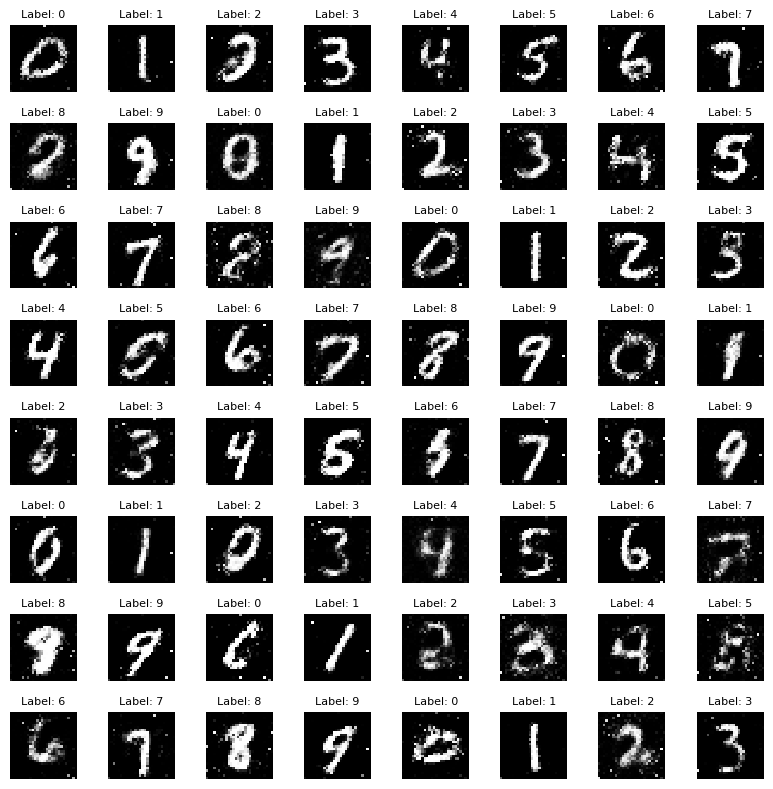

In [71]:
import matplotlib.pyplot as plt

with torch.no_grad():
    sample_noise = torch.randn(64, noise_dim, device=device) # 64 образца случайного шума, каждый из которых имеет размерность noise_dim
    sample_labels = torch.arange(0, 64, device=device) % num_classes
    sample_labels_onehot = F.one_hot(sample_labels, num_classes).float() # С помощью функции F.one_hot получите массив векторов - закодированных меток классов для вашего батча
    fake_samples = generator(sample_noise, sample_labels_onehot)

    fig, axes = plt.subplots(8, 8, figsize=(8, 8))
    for i, ax in enumerate(axes.flat):
        img = fake_samples[i].cpu().view(28, 28).numpy()
        ax.imshow(img, cmap="gray", interpolation="nearest")
        ax.set_title(f"Label: {sample_labels[i].item()}", fontsize=8)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Примеры генераций, которые должны у вас получиться

## Vanilla VAE

Восстановление

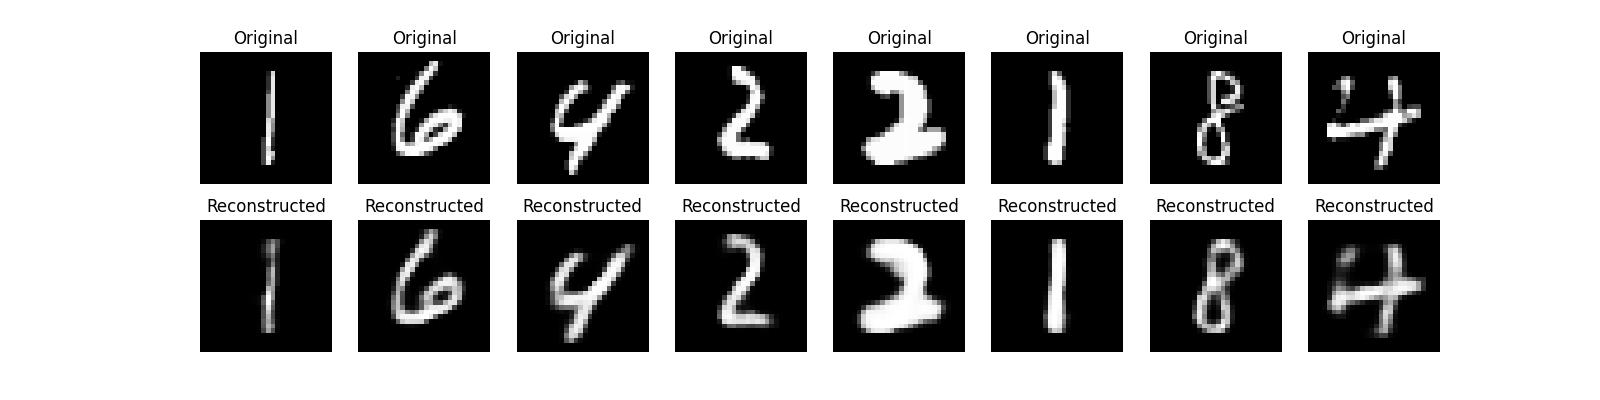

Генерация

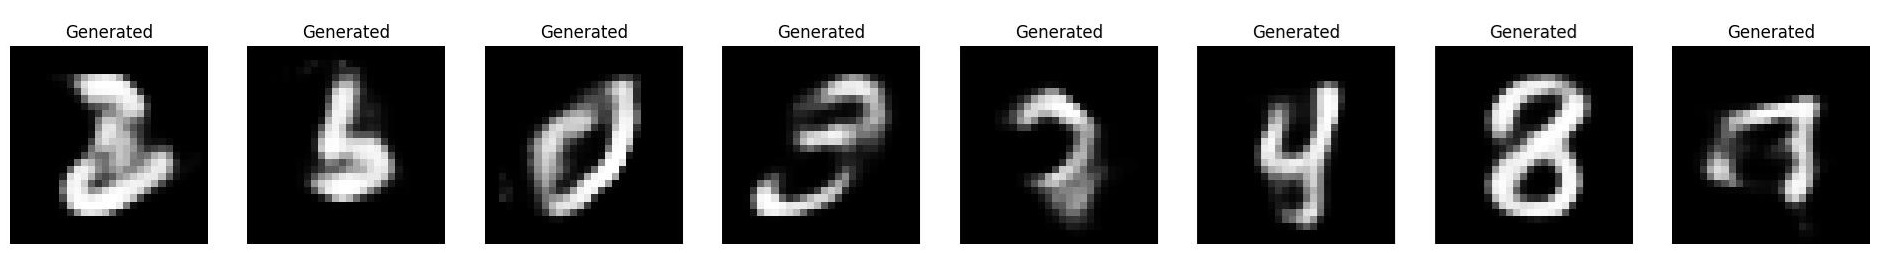

## CVAE

Восстановление

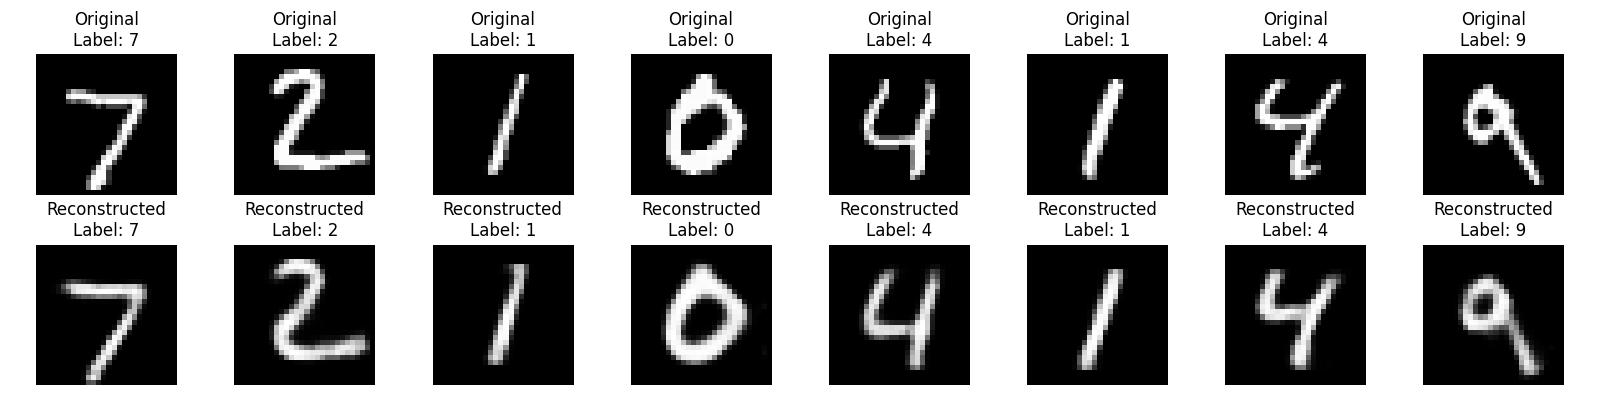

Генерация

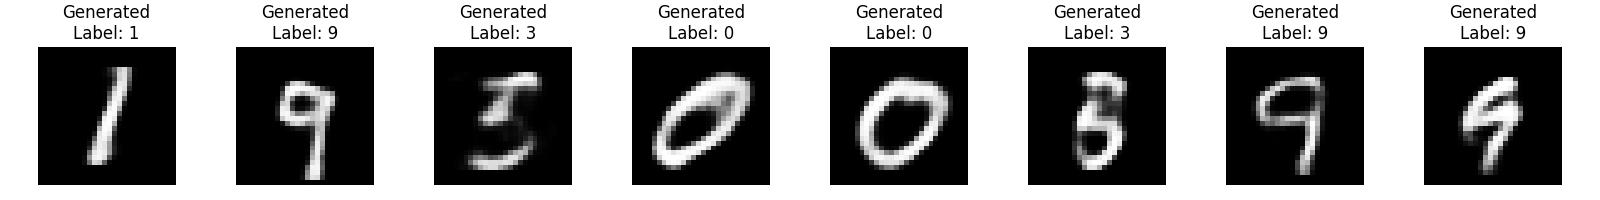

## Улучшенный CVAE

Восстановление

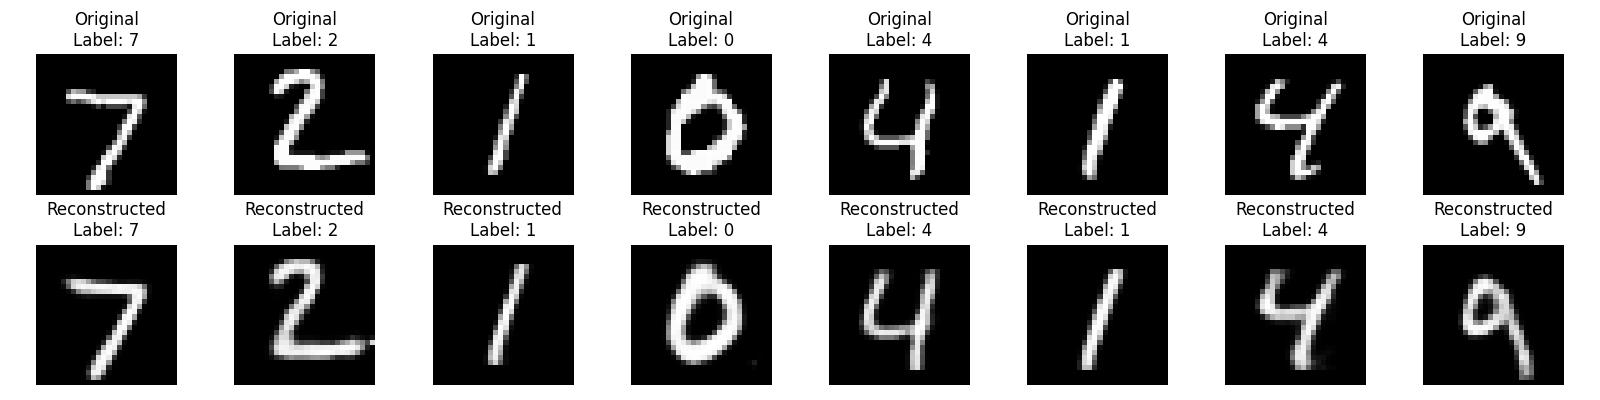

Генерация

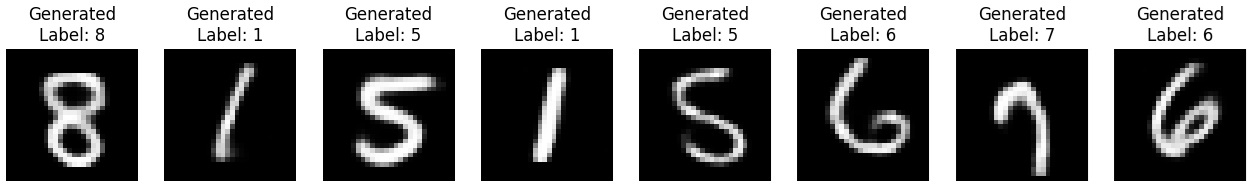

## Vanilla GAN

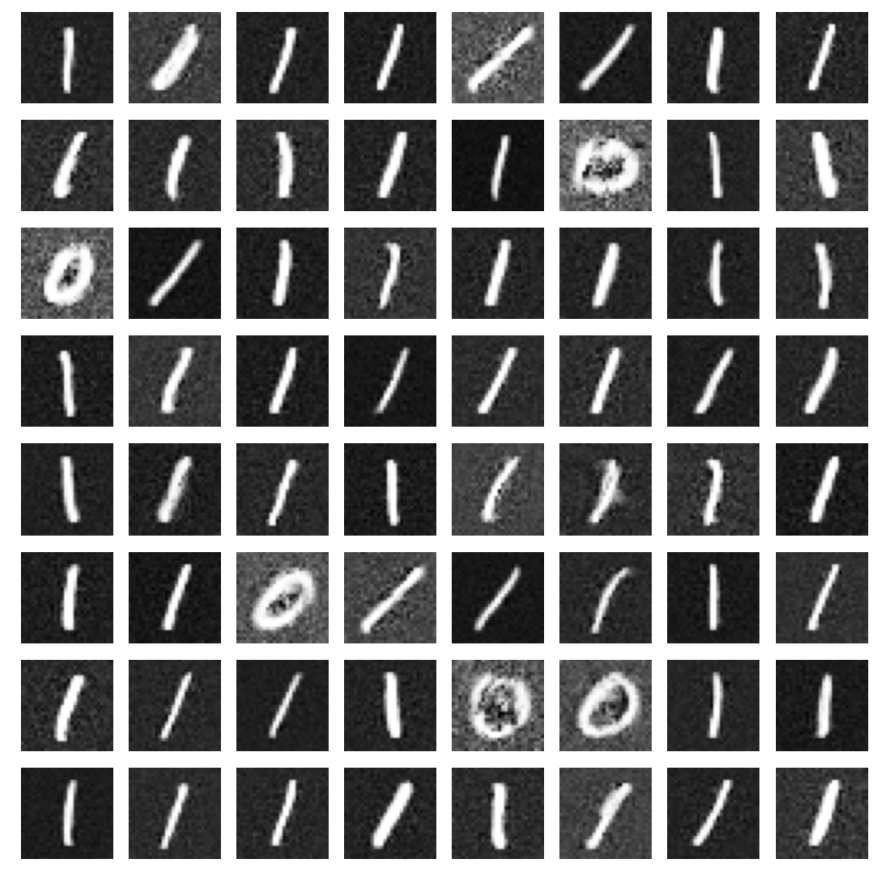

## CGAN

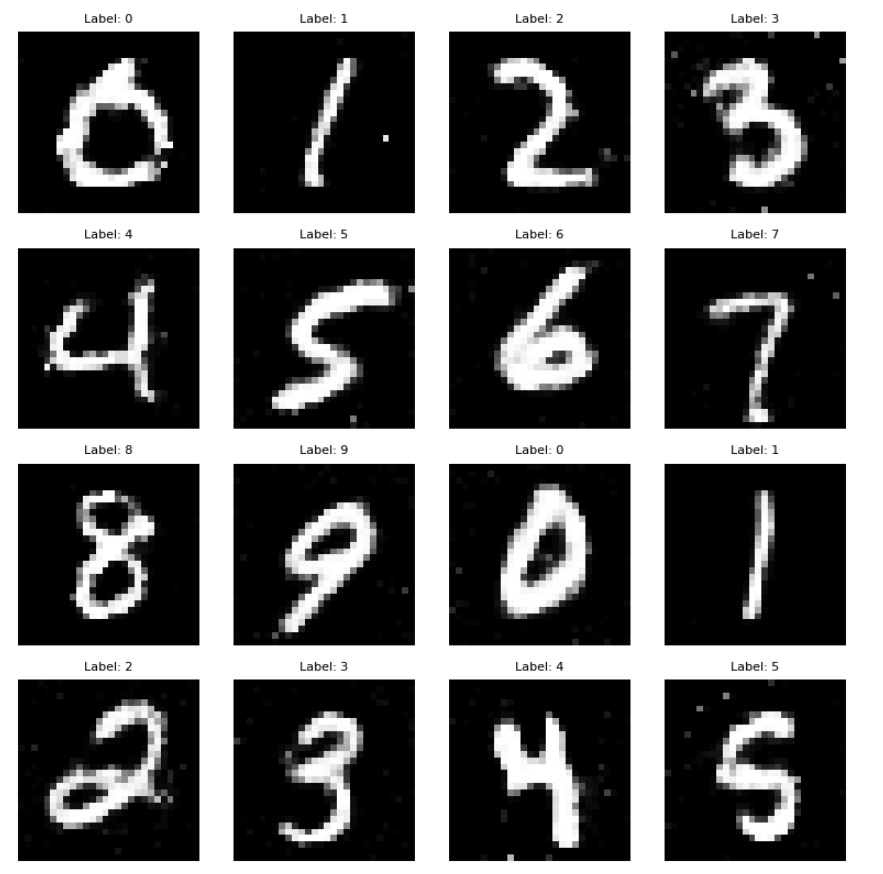

# Задача 3: Задачи со звёздочкой


## Анализ латентного пространства и интерполяция (для VAE и GAN) (1 балл)

Проведите интерполяцию между двумя изображениями: выберите две точки в латентном пространстве и сгенерируйте промежуточные изображения. Задание выполняется на моделях с условной генерацией.

Оцените, насколько плавно и семантически осмысленно происходит переход между различными классами.

In [ ]:
def interpolate_images(generator, first_dim, num_classes, class1, class2, num_interpolations=10):
  z1 = torch.randn(1, first_dim)
  z2 = torch.randn(1, first_dim)

  l1 = torch.zeros(1, num_classes)
  l1[0, class1] = 1  # Класс 0
  l2 = torch.zeros(1, num_classes)
  l2[0, class2] = 1  # Класс 1

  num_interpolations = 10
  interpolated_images = []

  for alpha in np.linspace(0, 1, num_interpolations):
      z = alpha * z1 + (1 - alpha) * z2
      l = alpha * l1 + (1 - alpha) * l2

      z = z.to(DEVICE)
      l = l.to(DEVICE)

      with torch.no_grad():
          generated_image = generator(z, l)

      interpolated_images.insert(0, generated_image.squeeze().cpu().numpy())

  return interpolated_images

def plot_interpolated_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
    for i, img in enumerate(images):
        axes[i].imshow(img.reshape(28, 28), cmap='gray')
        axes[i].axis('off')
    plt.show()

interpolated_images = interpolate_images(model.decoder, latent_dim, num_classes, 5, 6)
plot_interpolated_images(interpolated_images)

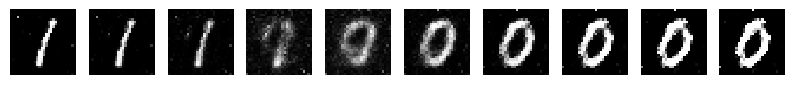

In [70]:
import numpy as np
num_classes = 10
class1 = 1
class2 = 0

# GAN

# Выбираем две случайные точки в латентном пространстве
z1 = torch.randn(1, noise_dim, device=device)
z2 = torch.randn(1, noise_dim, device=device)

c1 = torch.zeros(1, num_classes)
c1[0, class1] = 1  # Класс 0
c1 = c1.to(device)
c2 = torch.zeros(1, num_classes)
c2[0, class2] = 1  # Класс 1
c2 = c2.to(device)

# Генерируем промежуточные векторы в латентном пространстве
interpolated_images = []
num_steps = 10  # Количество шагов интерполяции

for alpha in np.linspace(0, 1, num_steps):
    z_interp = (1 - alpha) * z1 + alpha * z2  # Интерполяция в пространстве шума
    c_interp = (1 - alpha) * c1 + alpha * c2  # Интерполяция в пространстве меток классов
    z_interp = z_interp.to(device)
    c_interp = c_interp.to(device)

    with torch.no_grad():
      img = generator(z_interp, c_interp).cpu().detach().view(28, 28).numpy()

    # img = generator(z_interp, c_interp).cpu().detach().view(28, 28).numpy()
    interpolated_images.append(img)

# Визуализируем результат
fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 1))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i], cmap="gray", interpolation="nearest")
    ax.axis("off")

plt.show()


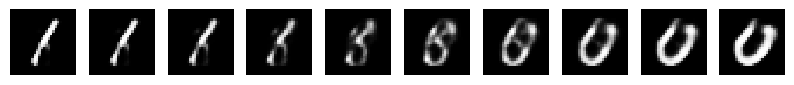

In [48]:
# Выбираем две случайные точки в латентном пространстве
z1 = torch.randn(1, latent_dim, device=device)
z2 = torch.randn(1, latent_dim, device=device)

c1 = torch.zeros(1, num_classes)
c1[0, class1] = 1  # Класс 0
c1 = c1.to(device)
c2 = torch.zeros(1, num_classes)
c2[0, class2] = 1  # Класс 1
c2 = c2.to(device)

# Генерируем промежуточные векторы в латентном пространстве
interpolated_images = []
num_steps = 10  # Количество шагов интерполяции

for alpha in np.linspace(0, 1, num_steps):
    z_interp = (1 - alpha) * z1 + alpha * z2  # Интерполяция в пространстве шума
    c_interp = (1 - alpha) * c1 + alpha * c2  # Интерполяция в пространстве меток классов
    z_interp = z_interp.to(device)
    c_interp = c_interp.to(device)

    with torch.no_grad():
      img = model.decoder(z_interp, c_interp).cpu().detach().view(28, 28).numpy()

    # img = generator(z_interp, c_interp).cpu().detach().view(28, 28).numpy()
    interpolated_images.append(img)

# Визуализируем результат
fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 1))
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i], cmap="gray", interpolation="nearest")
    ax.axis("off")

plt.show()


## Примеры результатов визуализации интерполяции

### VAE

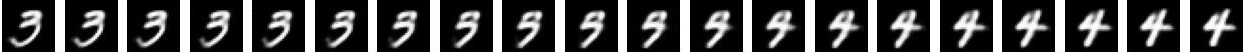

### GAN

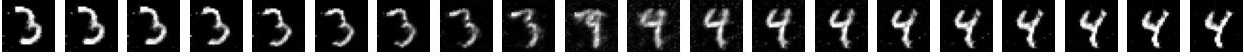

# Контрольные вопросы

### Общие вопросы:

1. Какая модель дает самые четкие изображения? Почему?

2. Рефлексия: Какая архитектура модели показалась вам наиболее интересной? Почему?
  
1. Что такое вариационный автокодировщик (VAE)?  
2. В чем заключается принцип работы генеративно-состязательной сети (GAN)?  
3. Какие основные компоненты входят в архитектуру VAE и GAN?  
4. Для чего используется латентное пространство в VAE?  
5. Что такое репараметризация (reparameterization trick) в VAE и зачем она нужна?  

---

### Вопросы по Variational Autoencoder (VAE):  
8. Какова роль KL-дивергенции в функции потерь VAE?  
7. Какая функция ошибки используется для реконструкции изображений в VAE?  
8. Как в Conditional VAE и Conditional GAN происходит передача метки класса?  

---

### Вопросы по Generative Adversarial Network (GAN):  
11. Какие задачи выполняют генератор и дискриминатор в GAN?
10. Как осуществляется обучение генератора и дискриминатора?  
11. В чем различие между Vanilla GAN и Conditional GAN?  

---

### Вопросы по реализации и обучению моделей:  
14. Как производится загрузка набора данных MNIST в PyTorch?  
18. Почему в обучении моделей используется метод обратного распространения ошибки?

---

# Формат сдачи


Для сдачи работы без очной защиты нужно будет предоставить следующие артефакты:
  1. Ссылка на ноутбук в формте .ipynb в гит-репозитории, где будут представлены реализации моделей и визуализации результатов работы моделей.

Ссылки на все артефакты должны быть загружены в LMS до дедлайна. Кнопка "отправлено" должна быть нажата, черновики не рассматриваются.

При очной сдаче необходимо будет ответить на вопросы из секции "Контрольные вопросы". Вам будут заданы 2-4 (на усмотрение принимающего) случайных вопроса.